Reducing NIRCam Imaging Data
---
**Author**: Sandro Tacchella (st578@cam.ac.uk) 

**Latest Update**: 13 September 2022

This notebook follows the example of and includes some text and explanations from STScI's [JWebbinar 3: “Pipeline in Imaging mode”](https://www.stsci.edu/jwst/science-execution/jwebbinars) and [JWebbinar 13: “CEERS NIRCam and MIRI Imaging”](https://www.stsci.edu/jwst/science-execution/jwebbinars). See the notebooks from the JWebbinar for more detailed information about running the pipeline.

<div class="alert alert-block alert-info">
    <h3><u><b>Notebook Goals</b></u></h3>
    <ul>Take a ERO/SMACS NIRCam pointing through all three stages of the JWST Calibration Pipeline. Specifically, we will:</ul>
    <ul>    
      <li>demonstrate calling the pipeline on a single image using all three calling methods; </li>
      <li>create partial mosaics in two filters, combining three dithered exposures; </li>
      <li>describe how to reduce all images for the pointing and produce full mosaics using the command line and batch scripts. </li>    
    </ul>
</div>

## Table of Contents
* [Introduction](#intro)
* [Pipeline Resources and Documentation](#resources)
* [Imports](#imports)
* [Methods for Calling Steps/Pipelines](#calling_methods)
* [Parameter Reference Files](#parameter_reffiles)
* [calwebb_detector1 - Ramps to Slopes](#detector1) 
   * [run() method](#run_method_detector1)
   * [call() method](#call_method_detector1)
   * [command line](#command_line_detector1)
* [Custom Step - Correction for Image Striping](#striping)
* [calwebb_image2 - Calibrated Slope Images](#image2)
   * [run() method](#run_method_image2)
   * [call() method](#call_method_image2)
   * [command line](#command_line_image2)
* [Association Files](#associations)
* [Break - Reducing Additional Images](#break)
* [calwebb_image3 - Ensemble calibrations](#image3) 
   * [run() method](#run_method_image3)
   * [call() method](#call_method_image3)
   * [command line](#command_line_image3)

<a id='intro'></a>
## Introduction

Description of ERO programmes: https://arxiv.org/abs/2207.13067. In this notebook, we'll take a subset of ERO/SMACS NIRCam images through the full JWST Calibration Pipeline. 

**DATA**

The ERO/SMACS pointing includes 270 raw (`uncals/*uncal.fits`) images, corresponding to roughly 20 GB of data:

* 216 each for F090W, F150W and F200W (8 short wavelength detectors x 9 dithers)
* 54 each for F277W, F356W and F444W (2 long wavelength detectors x 9 dithers)

**In this notebook, we will demonstrate how to run the JWST Calibration Pipeline on two of the raw images:** 

* jw02736001001_02101_00001_nrca1_uncal.fits - an F090W image
* jw02736001001_02101_00001_nrcalong_uncal.fits - an F277W image

We choose these two images as an example. Running Stages 1 and 2 of the pipeline on all images is identical to the process we demonstrate here on these two images. 

<a id='resources'></a>
## Pipeline Resources and Documentation

There are several different places to find information on installing and running the pipeline. This notebook will provide examples of running the pipeline on a handful of images, but will not demonstrate all options and features. Please see the following links for more in-depth instructions and documentation.

* [High-level description of all pipeline stages and steps](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/main.html) from the `jwst` software documentation pages.

* JWST Documentation (JDox) for each pipeline stage, including a short summary of what each step does:

  * [JDox page for the Stage 1 pipeline](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_detector1) 

  * [JDox page for the Stage 2 pipeline](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_image2)
  
  * [JDox page for the Stage 3 pipeline](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_image3)
  
* [JWebbinar 3 notebooks and presentations](https://stsci.app.box.com/s/m3rb85ts4qzcz8t6tpgclcous2zdxaey)

* [`jwst` package documentation](https://jwst-pipeline.readthedocs.io/en/latest/jwst/introduction.html) including how to run the pipeline, input/output files, etc.

* [`jwst` package GitHub repository](https://github.com/spacetelescope/jwst/blob/master/README.md), including installation instructions

* [Help Desk](https://stsci.service-now.com/jwst?id=sc_cat_item&sys_id=27a8af2fdbf2220033b55dd5ce9619cd&sysparm_category=e15706fc0a0a0aa7007fc21e1ab70c2f): If you have any questions or problems regarding the pipeline, submit a ticket to the Help Desk

<a id='installation'></a>
### Installation

<div class="alert alert-block alert-info">
    Before running this notebook, you will have to first install the <code>jwst</code> package. We recommend installing <strong>version 1.7.3</strong>, as that is the latest version tested with this notebook. 
    
**NOTE:** The `jwst` package requries Python 3.7+ <br><br>
    
The recommended way to install the pipeline is via `pip`. Follow the steps below to create a new conda environment, activate that environment, and then install the latest released version of the pipeline. You can name your environment anything you like. In the lines below, replace `<env_name>` with your chosen environment name.

>`conda create -n <env_name> python`<br>
>`conda activate <env_name>`<br>
>`pip install jwst==1.7.3`

You can download the latest released version by excluding `==1.7.3` from the `pip install jwst` command. For more detailed instructions on the various ways to install the package, including installing more recent development versions of the pipeline, see the [installation instructions](https://github.com/spacetelescope/jwst/blob/master/README.md) on GitHub.
    
</div>

<a id='reference_files'></a>
### Reference Files

[Calibration reference files](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/jwst-data-calibration-reference-files) are a collection of FITS and ASDF files that are used to remove instrumental signatures and calibrate JWST data.
For example, there are reference files handling the identification of bad pixels or those affected by saturation or persistence, the removal of dark current or flat field structure, flux calibration, etc.

When running a pipeline or pipeline step, the pipeline will automatically look for any required reference files in a pre-defined local directory. If the required reference files are not present, they will automatically be downloaded from the Calibration Reference Data System (CRDS) at STScI.
    
<div class="alert alert-block alert-info">
    
You will have to specify a local directory in which to store reference files, along with the server to use to download the reference files from CRDS. To accomplish this, there are two environment variables that should be set prior to calling the pipeline. These are the `CRDS_PATH` and `CRDS_SERVER_URL` variables. In the example below, reference files will be downloaded to the "crds_cache" directory under the home directory.

>`$ export CRDS_PATH=$HOME/crds_cache`<br>
>`$ export CRDS_SERVER_URL=https://jwst-crds.stsci.edu`<br>
OR:<br>
`os.environ["CRDS_PATH"] = "/user/myself/crds_cache"`<br>
`os.environ["CRDS_SERVER_URL"] = "https://jwst-crds.stsci.edu"`<br>

The first time you run the pipeline, the CRDS server should download all of the context and reference files that are needed for that pipeline run, and dump them into the `CRDS_PATH` directory. Subsequent executions of the pipeline will first look to see if it has what it needs in `CRDS_PATH` and anything it doesn't have will be downloaded from the STScI cache. 
</div>

<strong>Note:</strong>The <code>CRDS_PATH</code> directory will likely end up with **~10 GB** after running the pipeline steps in this notebook.</div>


You can either relaunch this notebook after setting these environment variables, or you can set them using the following cells:

In [ ]:
# Uncomment below to set CRDS_PATH, CRDS_SERVER_URL, and CRDS_CONTEXT

# Make sure to replace with the path to your CRDS cache directory
%env CRDS_PATH=/home/crds_cache/
%env CRDS_SERVER_URL=https://jwst-crds.stsci.edu
%env CRDS_CONTEXT=jwst_0970.pmap

<a id='imports'></a>
## Imports

In [1]:
import os
import numpy as np
import asdf
import json

# JWST pipeline-related modules
from jwst.datamodels import dqflags

# The entire jwst pipeline
from jwst.pipeline import calwebb_detector1
from jwst.pipeline import calwebb_image2
from jwst.pipeline import calwebb_image3
from jwst import datamodels

# importing an individual pipeline step
from jwst.skymatch import SkyMatchStep

# Custom scripts for use later
from plotimages import plot_images
from remstriping import measure_striping


Set up matplotlib for plotting

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Use this version for non-interactive plots (easier scrolling of the notebook)
#%matplotlib inline

# Use this version if you want interactive plots
#%matplotlib notebook
%matplotlib inline

# These gymnastics are needed to make the sizes of the figures
# be the same in both the inline and notebook versions
#%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

# You may want to change the following configurations to customize 
# figure sizes and resolutions
rcParams['figure.figsize'] = [11,8]
rcParams['figure.dpi'] = 80
rcParams['savefig.dpi'] = 80

Check which version of the pipeline you are running (we recommend v1.3.3 with these simulated images):

In [ ]:
import jwst
print(jwst.__version__)

Check that the CRDS environment variables are set

In [3]:
try:
    print(os.environ['CRDS_PATH'])
except KeyError:
    print('CRDS_PATH environment variable not set!')

try:
    print(os.environ['CRDS_SERVER_URL'])
except KeyError:
    print('CRDS_SERVER_URL environment variable not set!')

try:
    print(os.environ['CRDS_CONTEXT'])
except KeyError:
    print('CRDS_CONTEXT environment variable not set!')

/Users/sandrotacchella/ASTRO/cache/crds_cache
https://jwst-crds.stsci.edu
CRDS_CONTEXT environment variable not set!


Set the directories for pipeline outputs and source data 

In [4]:
data_dir = '/Users/sandrotacchella/ASTRO/JWST/jwst_nircam_reduction_workshop/data'
output_dir = os.path.join(os.getcwd(), 'calibrated')
if not os.path.exists(output_dir):
    os.mkdir(output_dir)


<a id='calling_methods'></a>
## Methods for Calling Steps/Pipelines

There are three common methods by which the pipeline or pipeline steps can be called. From within python, the `run()` and `call()` methods of the pipeline or step classes can be used. Alternatively, the `strun` command can be used from the command line. Within this notebook, we show examples of all three methods. 

When using the `call()` method or `strun`, optional input parameters can be specified via [parameter reference files](#parameter_reffiles). When using the `run()` method, these parameters are instead specified within python.

As a quick example, the following three cells demonstrate how to call the pipeline with all default parameter values. In these cases, the pipeline falls back to retrieving default parameter values from the pipeline code itself, or by retrieving the default parameter reference file stored in CRDS.

<div class="alert alert-block alert-info">
    
Using the run() method: default parameter values come from the pipeline itself
```    
 >>>   detector1 = calwebb_detector1.Detector1Pipeline()
 >>>   run_output = detector1.run(uncal_file)
```    
</div>

<div class="alert alert-block alert-info">
    
Using the call() method: default parameter reference file retrieved from CRDS
```
>>>    detector1 = calwebb_detector1.Detector1Pipeline()
>>>    call_output = detector1.call(uncal_file)
```    
</div>

<div class="alert alert-block alert-info">
    
Using strun on the command line with all default parameter values:    
```
    strun jwst.pipeline.Detector1Pipeline jw02736001001_02101_00001_nrca1_uncal.fits
```
    
</div>

<a id='parameter_reffiles'></a>
## Parameter Reference Files

When calling a pipeline or pipeline step using the `call()` method or `strun` on the command line, [parameter reference files](https://jwst-pipeline.readthedocs.io/en/stable/jwst/stpipe/config_asdf.html#config-asdf-files) can be used to specify values for input parameters. These reference files are [asdf](https://asdf.readthedocs.io/en/stable/) format and appear somewhat similar to json files when examined in a text editor. 

Versions of parameter reference files containing default parameter values for each step and pipeline are available in CRDS. When using the `call()` method, if you do not specify a parameter reference file name in the call, the pipeline or step will retrieve and use the appropriate file from CRDS, which will then run the pipeline or step with the parameter values in that file. If you provide the name of a parameter reference file, then the parameter values in that file will take precedence. For any parameter not specified in your parameter reference file, the pipeline will use the default value.

When using `strun`, the parameter reference file is a required input in order to specify non-default parameter values. 

As an example, you can save a copy of the default parameter file with the command:

    strun calwebb_detector1 jw02736001001_02101_00001_nrca1_uncal.fits --save-parameters detector1_params.asdf
    
This file can then be edited to change the default values and used when calling the pipeline. We have provided parameter files for each pipeline stage that we have edited to reflect how we run the pipeline on ERO/SMACS data.

In [5]:
# Define the parameter files here for convenience
detector1_paramfile = os.path.join(data_dir, 'detector1_edited.asdf')
image2_paramfile = os.path.join(data_dir, 'image2_edited.asdf')
image3_swc_paramfile = os.path.join(data_dir, 'image3_swc_edited.asdf')
image3_lwc_paramfile = os.path.join(data_dir, 'image3_lwc_edited.asdf')

Let's take a look at the contents of a parameter reference file. We'll open it using the asdf package, and use the `tree` attribute to see what's inside:

In [6]:
det1_reffile = asdf.open(detector1_paramfile)
det1_reffile.tree

{'asdf_library': {'author': 'The ASDF Developers',
  'homepage': 'http://github.com/asdf-format/asdf',
  'name': 'asdf',
  'version': '2.8.1'},
 'history': {'extensions': [{'extension_class': 'asdf.extension.BuiltinExtension',
    'software': {'name': 'asdf', 'version': '2.8.1'}}]},
 'class': 'jwst.pipeline.calwebb_detector1.Detector1Pipeline',
 'meta': {'author': '<SPECIFY>',
  'date': '2021-06-21T12:52:24',
  'description': 'Parameters for calibration step jwst.pipeline.calwebb_detector1.Detector1Pipeline',
  'instrument': {'name': '<SPECIFY>'},
  'origin': '<SPECIFY>',
  'pedigree': '<SPECIFY>',
  'reftype': '<SPECIFY>',
  'telescope': '<SPECIFY>',
  'useafter': '<SPECIFY>'},
 'name': 'Detector1Pipeline',
 'parameters': {'input_dir': 'uncals',
  'output_dir': 'calibrated',
  'output_ext': '.fits',
  'output_file': None,
  'output_use_index': True,
  'output_use_model': False,
  'post_hooks': [],
  'pre_hooks': [],
  'save_calibrated_ramp': False,
  'save_results': True,
  'search_ou

The top part of the file contains various metadata entries about the file itself. Below that, you'll see a `'name'` entry, which lists `Detector1Pipeline` as the class to which these parameters apply. The next line contains the `parameters` entry, which lists parameters and values attached to the pipeline itself. Below this is the `steps` entry, which contains a list of dictionaries. Each dictionary refers to one step within the pipeline, and specifies parameters and values that apply to that step. If you look through these entries, you'll see the same parameters and values that we specified manually when using the `run()` method below.

In [7]:
# Don't forget to close the file
det1_reffile.close()

---
<a id='detector1'></a>
## The calwebb_detector1 pipeline: Ramps to Slopes

**Description**

The Stage 1 [*calwebb_detector1* pipeline](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html#calwebb-detector1) applies basic detector-level corrections to all exposure types (imaging, spectroscopic, coronagraphic, etc.). It is applied to one exposure at a time, beginning with an uncalibrated multiaccum ramp (*_uncal.fits file). Each input raw data file is composed of one or more ramps (integrations) containing increasing count values from the non-destructive detector readouts. For details on multiaccum files and data collection, see the JDox page on [how up-the-ramp readouts work](https://jwst-docs.stsci.edu/understanding-exposure-times#UnderstandingExposureTimes-uptherampHowup-the-rampreadoutswork). The final output from this call is an uncalibrated slope image which is ready to go into the Stage 2 pipeline. "Uncalibrated" in this case means that the data are in units of DN/sec. In Stage 2 the flux calibration will be applied, at which point the data will be in physical units (e.g. MJy/sr) and referred to as "calibrated".

All JWST data, regardless of instrument and observing mode, are processed through the Stage 1 pipeline. The corrections performed are the same across all near-IR instruments. See [Figure 1](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_detector1) on the *calwebb_detector1* algorithm page for a map of which steps are performed on NIR data.

In the sections below, we will run the entire Stage 1 pipeline on two uncalibrated NIRCam files. The pipeline is a wrapper which will string together all of the appropriate steps in the proper order. To explore how each individual step of the Stage 1 pipeline changes the input data, please see the ['Ramps to Slopes' notebook from JWebbinar 3](https://stsci.app.box.com/s/z5bznws56f9m1j505vhnpud35nxrjr50). 

**Inputs**

* A raw exposure (`*_uncal.fits`) containing the 4-dimensional raw data from all detector readouts: (ncols x nrows x ngroups x nintegrations).

**Outputs**

* A 2D countrate image (`*_rate.fits`) resulting from averaging over the exposure's integrations.
* A 3D countrate image (`*_rateints.fits`) containing the results of each integration in separate extensions.

**Note:** The ERO/SMACS exposures only have one integration, and so the `*_rate.fits` and `*_rateints.fits` files will be identical. The `*_rateints.fits` files can be deleted to save disk space.

<a id='run_method_detector1'></a>
#### Call the pipeline using the run() method

When using the `run()` method to execute a pipeline (or step), the pipeline class is first instantiated without the data to be processed. Optional input parameters are specified using attributes of the class instance. Finally, the call to the `run()` method is made and the data are supplied.  See here for [more examples of the run() method](https://jwst-pipeline.readthedocs.io/en/stable/jwst/stpipe/call_via_run.html).

The `run()` method does not take any kind of parameter reference file as input. If you wish to set values for various parameters, you must do that manually. Below, we set several parameters in order to show how it's done. 

Note that you can use the `spec` property to see the available parameters and default values for a pipeline step. For example:

> ```from jwst.refpix import RefPixStep```  
> ```print(RefPixStep.spec)``` 

will list the parameters and default values associated with the reference pixel subtraction step. The `spec` property is less useful for the pipelines themselves, as it does not show the parameters for the steps comprising the pipeline.

All steps and pipelines have several common parameters that can be set. 

* `save_results` specifies whether or not to save the output of that step/pipeline to a file. The default is False.
* `output_dir` is the directory into which the output files will be saved.
* `output_file` is the base filename to use for the saved result. Note that each step/pipeline will add a custom suffix onto output_file. 

We will use the `run()` method on the first of our raw files: `jw02736001001_02101_00001_nrca1_uncal.fits`

The following step can take a few minutes to run and will output a lot of logging information with details about what the pipeline is doing.

In [8]:
uncal_file = os.path.join(data_dir, 'uncals/jw02736001001_02101_00001_nrca1_uncal.fits')

# Create an instance of the pipeline class
detector1 = calwebb_detector1.Detector1Pipeline()

# Set some parameters that pertain to the
# entire pipeline
detector1.output_dir = output_dir
detector1.save_results = True

# Set some parameters that pertain to some of the individual steps
# turn on IPCStep
detector1.ipc.skip = False
# turn off PersistenceStep
detector1.persistence.skip = False

# Call the run() method
run_output = detector1.run(uncal_file)

2022-09-15 10:10:55,571 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2022-09-15 10:10:55,572 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2022-09-15 10:10:55,572 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2022-09-15 10:10:55,573 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2022-09-15 10:10:55,574 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2022-09-15 10:10:55,575 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2022-09-15 10:10:55,576 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2022-09-15 10:10:55,576 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2022-09-15 10:10:55,577 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2022-09-15 10:10:55,578 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2022-09-15 1

2022-09-15 10:10:57,105 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/sandrotacchella/ASTRO/cache/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0056.fits'.
2022-09-15 10:10:57,105 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/sandrotacchella/ASTRO/cache/crds_cache/references/jwst/nircam/jwst_nircam_mask_0062.fits'.
2022-09-15 10:10:57,105 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is '/Users/sandrotacchella/ASTRO/cache/crds_cache/references/jwst/nircam/jwst_nircam_persat_0027.fits'.
2022-09-15 10:10:57,106 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/sandrotacchella/ASTRO/cache/crds_cache/references/jwst/nircam/jwst_nircam_readnoise_0093.fits'.
2022-09-15 10:10:57,106 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2022-09-15 10:10:57,106 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference fi

2022-09-15 10:11:00,930 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done
2022-09-15 10:11:00,982 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 8, 2048, 2048) from jw02736001001_02101_00001_nrca1_uncal.fits>,).
2022-09-15 10:11:00,983 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/sandrotacchella/ASTRO/JWST/jwst_nircam_reduction_workshop/data/uncals'}
2022-09-15 10:11:00,997 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /Users/sandrotacchella/ASTRO/cache/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0056.fits
2022-09-15 10:11:01,101 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_DO_NOT_USE does

2022-09-15 10:11:34,373 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /Users/sandrotacchella/ASTRO/cache/crds_cache/references/jwst/nircam/jwst_nircam_gain_0092.fits
2022-09-15 10:11:34,408 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols
2022-09-15 10:11:34,408 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal
2022-09-15 10:11:58,081 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2022-09-15 10:11:58,505 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8
2022-09-15 10:11:58,506 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 1
2022-09-15 10:11:58,607 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done
2022-09-15 10:11:58,663 - stpipe.

<div class="alert alert-block alert-info">
    
**Note:** One of the most time-intensive steps of the *calwebb_detector1* pipeline is downloading the dark reference file (>3 GB) from CRDS (see the [Reference Files](#reference_files) section). It can sometimes happen that the CRDS server times out before the file is fully downloaded. In these cases, the above call to `run()` will crash. If this happens repeatedly, you man choose to manually download the dark at the following link: 
    
[https://jwst-crds.stsci.edu/](https://jwst-crds.stsci.edu/)
<br><br>
    
The downloaded dark should then be placed in your `$CRDS_PATH` directory at:

    $CRDS_PATH/crds_cache/references/jwst/nircam

</div>

You'll notice that in the `calibrated` directory there are now two new files: `jw02736001001_02101_00001_nrca1_rate.fits` and `jw02736001001_02101_00001_nrca1_rateints.fits`. They are both count rate images (DN/sec), and the `rate.fits` file will be passed to the Stage 2 pipeline. As described above, the `rateints.fits` file is identical to the `rate.fits` file because the ERO/SMACS observations involve only a single integration.

Let's compare the raw input file with the countrate output file. We'll plot the last group of the raw multiaccum ramp file (`group=8` below) to see the counts from the full ramp.

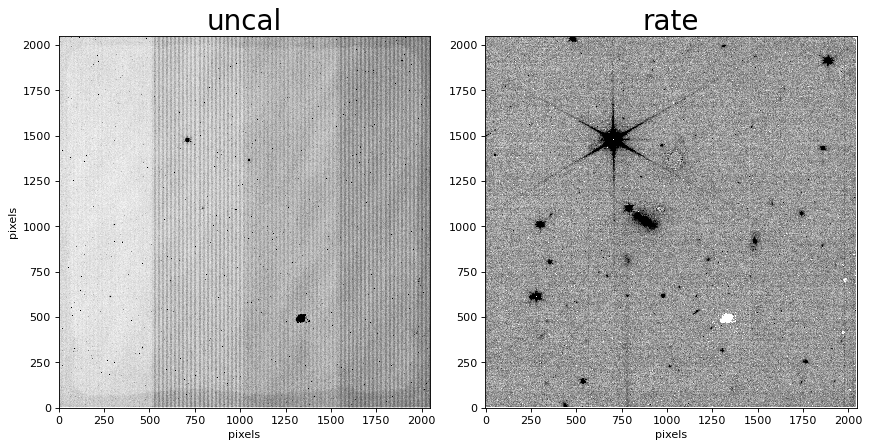

In [9]:
# Specify which group of the uncal exposure using the group keyword
# There are 8 groups in the exposures, counting from 0 
# Let's look at the last one (group=7)
plot_images(os.path.join(data_dir, 'uncals/jw02736001001_02101_00001_nrca1_uncal.fits'),
            os.path.join(output_dir, 'jw02736001001_02101_00001_nrca1_rate.fits'), 
            title1='uncal', title2='rate', group=7)

<a id='call_method_detector1'></a>
#### Call the pipeline using the call() method

When using the `call()` method, a single command will instantiate and run the pipeline (or step). The input data and optional parameter reference files are supplied in this single command. See here for [example usage of call() method](https://jwst-pipeline.readthedocs.io/en/stable/jwst/stpipe/call_via_call.html).

There are two options for calling the pipeline with the `call()` method: 

2. providing a nested dictionary of parameter values, and
2. using the parameter reference file.

We will demonstrate method (1) with the second uncal file, `jw02736001001_02101_00001_nrcalong_uncal.fits`. 

We also show how to use method (2) in a raw cell so as not to execute another call. If you wish to try it out, use the pull-down menu above to change the cell to be 'Code', and then execute it. (Or, Click 'Cell' > 'Cell Type' > 'Code')

<div class="alert alert-block alert-info">

<b>Method #1:</b>
In this case, build a nested dictionary that specifies parameter values for various steps, and provide it in the call to call().
</div>

In [10]:
uncal_file = os.path.join(data_dir, 'uncals/jw02736001001_02101_00001_nrcalong_uncal.fits')
parameter_dict = {'ipc': {'skip': False},
                  'persistence': {'skip': False}
                 }
call_output = calwebb_detector1.Detector1Pipeline.call(uncal_file, output_dir=output_dir, save_results=True,
                                                       steps=parameter_dict)


2022-09-15 10:13:25,671 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /Users/sandrotacchella/ASTRO/cache/crds_cache/references/jwst/nircam/jwst_nircam_pars-detector1pipeline_0002.asdf
2022-09-15 10:13:25,681 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2022-09-15 10:13:25,682 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2022-09-15 10:13:25,683 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2022-09-15 10:13:25,683 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2022-09-15 10:13:25,684 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2022-09-15 10:13:25,685 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2022-09-15 10:13:25,686 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2022-09-15 10:13:25,686 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2022-09-15 10:13:25,6

2022-09-15 10:13:25,920 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/Users/sandrotacchella/ASTRO/cache/crds_cache/references/jwst/nircam/jwst_nircam_ipc_0028.fits'.
2022-09-15 10:13:25,920 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/sandrotacchella/ASTRO/cache/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0052.fits'.
2022-09-15 10:13:25,920 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/sandrotacchella/ASTRO/cache/crds_cache/references/jwst/nircam/jwst_nircam_mask_0063.fits'.
2022-09-15 10:13:25,921 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is '/Users/sandrotacchella/ASTRO/cache/crds_cache/references/jwst/nircam/jwst_nircam_persat_0021.fits'.
2022-09-15 10:13:25,921 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/sandrotacchella/ASTRO/cache/crds_cache/references/jwst/nircam/jwst_nircam_readnoise_0080.fits'.
202

2022-09-15 10:13:28,832 - stpipe.Detector1Pipeline.refpix - INFO - The following parameter is not applicable and is ignored:
2022-09-15 10:13:28,832 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = False
2022-09-15 10:13:29,788 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done
2022-09-15 10:13:29,843 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 8, 2048, 2048) from jw02736001001_02101_00001_nrcalong_uncal.fits>,).
2022-09-15 10:13:29,844 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/sandrotacchella/ASTRO/JWST/jwst_nircam_reduction_workshop/data/uncals'}
2022-09-15 10:13:29,858 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity

2022-09-15 10:14:09,900 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /Users/sandrotacchella/ASTRO/cache/crds_cache/references/jwst/nircam/jwst_nircam_readnoise_0080.fits
2022-09-15 10:14:09,901 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /Users/sandrotacchella/ASTRO/cache/crds_cache/references/jwst/nircam/jwst_nircam_gain_0097.fits
2022-09-15 10:14:09,934 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols
2022-09-15 10:14:09,935 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal
2022-09-15 10:14:34,671 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2022-09-15 10:14:35,100 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8
2022-09-15 10:

<div class="alert alert-block alert-info">

<b>Method #2:</b>
Provide the name of the observation file, the pipeline-specific input paramters, and the name of the parameter reference file that specifies step-specific parameters
</div>

<a id='command_line_detector1'></a>
#### Call the pipeline using the command line

Calling a pipeline or step from the command line is similar to using the `call()` method. The data file to be processed, along with an optional parameter reference file and optional parameter/value pairs can be provided to the `strun` command. See here for [additional examples of command line calls](https://jwst-pipeline.readthedocs.io/en/stable/jwst/introduction.html?highlight=%22command%20line%22#running-from-the-command-line).

In the cell below we provide two commands that use `strun` to call the *calwebb_detector1* pipeline on the two uncal files. The pipeline class is contained in the parameter reference file, and so there is no need to specify it in the command itself. We also override the gain files as in the above examples. 

<div class="alert alert-block alert-info">

    
```
strun detector1_edited.asdf uncals/jw02736001001_02101_00001_nrca1_uncal.fits 
    
strun detector1_edited.asdf uncals/jw02736001001_02101_00001_nrcalong_uncal.fits 
```
</div>

[Top of Notebook](#top)

---
<a id='striping'></a>
## Custom Step - Correction for Image Striping

<div class="alert alert-block alert-success">
 
You may notice some horizontal and vertical striping patterns present in the `*_rate.fits` images. The striping is most likely due to [1/f noise related to the detector readout electronics](https://jwst-docs.stsci.edu/near-infrared-camera/nircam-instrumentation/nircam-detector-overview/nircam-detector-performance). <br><br>

We have found that the [RefPix step of *calwebb_detector1*](https://jwst-pipeline.readthedocs.io/en/stable/jwst/refpix/description.html) with `odd_even_columns=True` and `use_side_ref_pixels=True` does not fully remove the pattern, no matter what value is chosen for `side_smoothing_length`. Instead, we have developed a script, `remstriping.py`, to measure and remove the striping pattern from a countrate image. <br><br>

Below we use the `measure_striping` function to clean the two countrate images we have created so far. The striping patterns are measured using the following steps:
1. The appropriate flat field is applied to the countrate image, allowing for a cleaner measure of the striping patterns.
2. Source flux is masked out using the seed images output by Mirage. This method works for simulated data because we know the input positions of all sources. For real data, we would instead perform an iterative reduction, using the stacked exposures to determine the positions of sources and then repeating the reduction masking these source positions to measure the striping. We have included the Mirage seed images with the `*_uncal.fits` images in the `uncals` directory.
3. The background pedestal is measured and removed. 
4. The image is collapsed (using a sigma-clipped median) first along columns to measure the horizontal striping and then along rows to measure the vertical striping. 

The horizontal and vertical patterns are then subtracted from the input countrate image.<br><br>

**Note:** The original rate image file is copied to `*_rate_orig.fits`, and the output of `measure_striping` is saved to `*_rate.fits`, overwriting the input file.

    Args:

        image (str): image filename, including full relative path
        apply_flat (Optional [bool]): if True, identifies and applies the 
            corresponding flat field before measuring striping pattern. 
            Applying the flat first allows for a cleaner measure of the 
            striping, especially for the long wavelength detectors. 
            Default is True.
        mask_sources (Optional [bool]): If True, masks out sources in image
            before measuring the striping pattern so that source flux is 
            not included in the calculation of the sigma-clipped median.
            Sources are identified using the Mirage seed images.
            Default is True.
        seedim_directory (Optional [bool]): Directory containing 
            Mirage seed images, used if mask_sources is True. 
            Default is working directory.
        threshold (Optional [float]): threshold (in ADU/s) to use in the 
            seed images when identifying pixels to mask. This will depend on 
            the seed image and brightness of input sources. Default is 0.01
    
</div>

In [11]:
# measure and remove the horizontal and vertical striping from the two countrate images
rates = [os.path.join(output_dir,'jw02736001001_02101_00001_nrca1_rate.fits'),
         os.path.join(output_dir,'jw02736001001_02101_00001_nrcalong_rate.fits')]
for rate in rates:
    measure_striping(
        rate, apply_flat=False, mask_sources=False,
        seedim_directory=os.path.join(data_dir, 'uncals'),
        threshold=0.01
    )
    
# There will be some warnings related to empty slices in the images, where the rows and columns 
# of reference pixels along the image edges have been masked out of the median calculation. 

2022-09-15 10:14:36,136 - stpipe - INFO - Measuring image striping
2022-09-15 10:14:36,136 - stpipe - INFO - Working on /Users/sandrotacchella/ASTRO/JWST/jwst_nircam_reduction_workshop/calibrated/jw02736001001_02101_00001_nrca1_rate.fits
2022-09-15 10:14:36,177 - stpipe - INFO - Measuring the pedestal in the image
2022-09-15 10:14:36,236 - stpipe - INFO - Image median (unmasked and DQ==0): 0.061251
2022-09-15 10:14:36,477 - stpipe - INFO - Fit pedestal: 0.061029
2022-09-15 10:14:36,917 - stpipe - INFO - Copying input to /Users/sandrotacchella/ASTRO/JWST/jwst_nircam_reduction_workshop/calibrated/jw02736001001_02101_00001_nrca1_rate_orig.fits
2022-09-15 10:14:36,992 - stpipe - INFO - Saving cleaned image to /Users/sandrotacchella/ASTRO/JWST/jwst_nircam_reduction_workshop/calibrated/jw02736001001_02101_00001_nrca1_rate.fits
2022-09-15 10:14:37,447 - stpipe - INFO - Measuring image striping
2022-09-15 10:14:37,448 - stpipe - INFO - Working on /Users/sandrotacchella/ASTRO/JWST/jwst_nircam_r

Let's compare one of the countrate images before and after this correction.

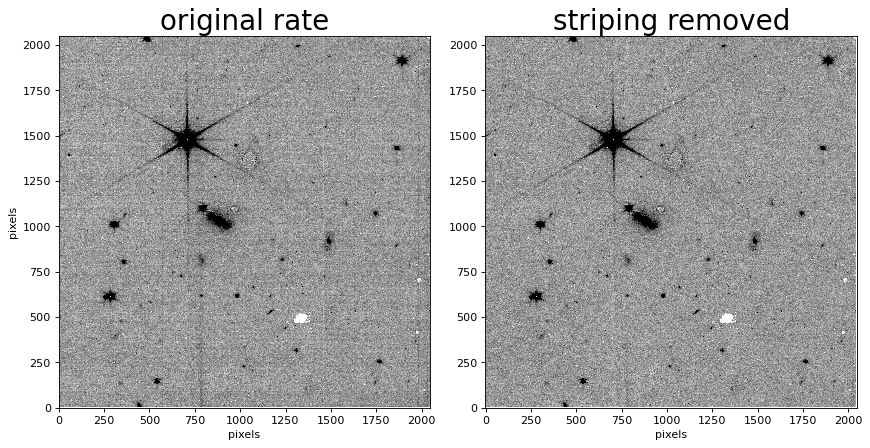

In [12]:
plot_images(os.path.join(output_dir, 'jw02736001001_02101_00001_nrca1_rate_orig.fits'),
            os.path.join(output_dir, 'jw02736001001_02101_00001_nrca1_rate.fits'), 
            title1='original rate', title2='striping removed')

We have removed the completely horizontal and vertical striping. There are still some striping patterns present in the image on the right, especially visible along the left edge, though these are at a slight angle and will be removed as part of the flat field correction in Stage 2. The difference between the left and right images may be easiest to see if you are using matplotlib in interactive mode and zoom in on a subsection of each image.  



[Top of Notebook](#top)

---
<a id='image2'></a>
## The calwebb_image2 pipeline: Calibrated Slope Images

The Stage 2 [*calwebb_image2* pipeline](https://jwst-pipeline.readthedocs.io/en/stable/jwst/pipeline/calwebb_image2.html) applies instrumental corrections and calibrations to the slope images output from Stage 1. This includes background subtraction, the creation of a full World Coordinate System (WCS) for the data, application of the flat field, and flux calibration. In most cases the final output is an image in units of surface brightness. Whereas the input files had suffixes of `*_rate.fits*`, the output files have suffixes of `*_cal.fits*`.

In addition to the steps above, by default the Stage 2 pipeline will also run the [Resample](https://jwst-pipeline.readthedocs.io/en/stable/jwst/resample/main.html) step on the calibrated images, in order to remove the effects of instrument distortion. This step outputs files with the suffix `*_i2d.fits*` that contain "rectified" images. However, these files are meant only for user examination of the data. It is the `*_cal.fits*` files that are passed on to Stage 3 of the pipeline.

All JWST imaging mode data, regardless of instrument, are processed through the *calwebb\_image2* pipeline. The steps and the order in which they are performed is the same for all data. See [Figure 1](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_image2) on the *calwebb_image2* algorithm page for a map of the steps are performed on the input data.

**Inputs**
* A 2D countrate image (`*_rate.fits`) in units of DN/sec. The user can input a single image file or an association file listing several files, in which case the processing steps will be applied to each input exposure, one at a time.

**Outputs**
* A 2D calibrated, but unrectified, exposure (`*_cal.fits`) in units of MJy/sr
* A 2D resampled, or rectified, image (`*_i2d.fits`) in units of MJy/sr


**Note:** At this stage, the resampled `*_i2d.fits` images are intended for **quick-look use only**, while the `*_cal.fits` files are passed through for Stage 3 processing. We have chosen to **skip ResampleStep of *calwebb_image2* to save on both processing time and disk space**. If you wish to perform this step to inspect the outputs, change the `skip: true` in the `jwst.resample.resample_step.ResampleStep` dictionary of the `image2_edited.asdf` parameter file (line 136) to `skip: false`. Alternatively comment out the line `image2.resample.skip = True` in the cell using the `run()` method.

<a id='run_method_image2'></a>
#### Call the pipeline using the run() method

As before, we will use the `run()` method on the first of our uncalibrated files: `jw02736001001_02101_00001_nrca1_rate.fits`

In [13]:
rate_file = 'calibrated/jw02736001001_02101_00001_nrca1_rate.fits'

# Create an instance of the pipeline class
image2 = calwebb_image2.Image2Pipeline()

# Set some parameters that pertain to the
# entire pipeline
image2.output_dir = output_dir
image2.save_results = True
# turn off the ResampleStep, comment out to produce the 
# individual rectified *_i2d.fits for quick-look checks
image2.resample.skip = True

# Call the run() method
image2.run(rate_file)

2022-09-15 10:15:40,370 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.
2022-09-15 10:15:40,372 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2022-09-15 10:15:40,375 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2022-09-15 10:15:40,377 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2022-09-15 10:15:40,378 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.
2022-09-15 10:15:40,379 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.
2022-09-15 10:15:40,448 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('calibrated/jw02736001001_02101_00001_nrca1_rate.fits',).
2022-09-15 10:15:40,451 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/sandrotacchella/ASTRO/JWST/jwst_nircam_reduction_workshop/calibrated', 'output_ext': '.fits

2022-09-15 10:15:41,144 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done
2022-09-15 10:15:41,201 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(2048, 2048) from jw02736001001_02101_00001_nrca1_rate.fits>,).
2022-09-15 10:15:41,202 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': 'calibrated', 'inverse': False, 'source_type': None}
2022-09-15 10:15:41,219 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /Users/sandrotacchella/ASTRO/cache/crds_cache/references/jwst/nircam/jwst_nircam_photom_0106.fits
2022-09-15 10:15:41,220 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /Users/sandrotacchella/ASTRO/cache/crds_cache/references/jwst/nirc

[<ImageModel(2048, 2048) from jw02736001001_02101_00001_nrca1_cal.fits>]

You'll notice that in the `calibrated` directory there is now another new file: `jw02736001001_02101_00001_nrca1_cal.fits`. It is a calibrated image in units of MJy/sr. 

<a id='call_method_image2'></a>
#### Call the pipeline using the call() method

We will demonstrate the `call()` method with the second countrate file, `jw02736001001_02101_00001_nrcalong_rate.fits`. 

In [14]:
rate_file = 'calibrated/jw02736001001_02101_00001_nrcalong_rate.fits'
call_output = calwebb_image2.Image2Pipeline.call(rate_file, output_dir=output_dir,
                                                  save_results=True,
                                                  config_file=image2_paramfile)

2022-09-15 10:15:53,372 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.
2022-09-15 10:15:53,373 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2022-09-15 10:15:53,374 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2022-09-15 10:15:53,375 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2022-09-15 10:15:53,375 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.
2022-09-15 10:15:53,376 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.
2022-09-15 10:15:53,436 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('calibrated/jw02736001001_02101_00001_nrcalong_rate.fits',).
2022-09-15 10:15:53,439 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/sandrotacchella/ASTRO/JWST/jwst_nircam_reduction_workshop/calibrated', 'output_ext': '.f

2022-09-15 10:15:53,898 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'calibrated', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': 'calibrated', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}
2022-09-15 10:15:54,116 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done
2022-09-15 10:15:54,176 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(2048, 2048) from jw02736001001_02101_00001_nrcalong_rate.fits>,).
2022-09-15 10:15:54,177 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'calibrated', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False

<a id='command_line_image2'></a>
#### Call the pipeline using the command line

In the cell below we provide two commands that use `strun` to call the *calwebb_image2* pipeline on the two countrate files. 

<div class="alert alert-block alert-info">

    
```
strun image2_edited.asdf calibrated/jw02736001001_02101_00001_nrca1_rate.fits 
   
strun image2_edited.asdf calibrated/jw02736001001_02101_00001_nrcalong_rate.fits 
    
```
</div>

After running *calwebb_image2*, let's compare the countrate input file with the calibrated output file for the A5 detector.

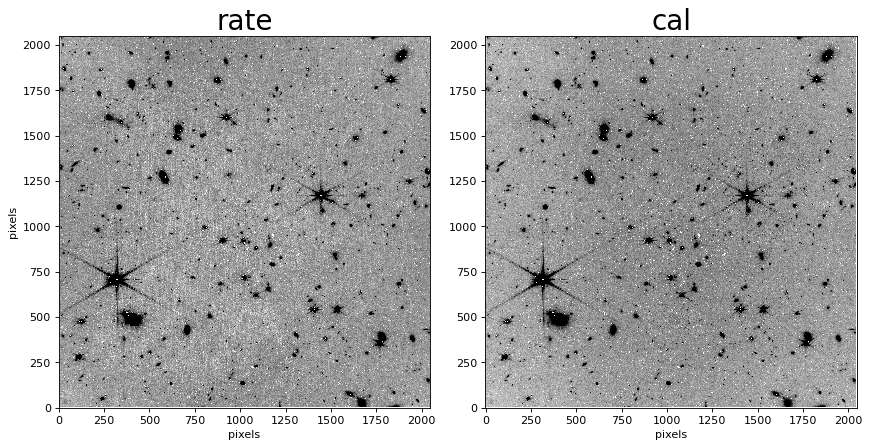

In [15]:
plot_images(os.path.join(output_dir, 'jw02736001001_02101_00001_nrcalong_rate.fits'),
            os.path.join(output_dir, 'jw02736001001_02101_00001_nrcalong_cal.fits'), 
            title1='rate', title2='cal')

The most notable difference between the `rate.fits` image on the left and the `cal.fits` image on the right is the application of the flat field correction. The `cal.fits` image is also now in units of MJy/sr rather than DN/sec.

---
<a id='associations'></a>
## Association Files

The Stage 3 pipeline must be called using a json-formatted file called an ["association" (ASN) file](https://jwst-pipeline.readthedocs.io/en/stable/jwst/associations/index.html). The association file presents your data files in organized groups. When retrieving your observations from MAST, you will be able to download the association files for your data along with the fits files containing the observations.

We have created ASN files for the Stage 3 runs we demonstrate in this notebook:

* `f090w_nrca1.json` - groups the three F090W calibrated images we will combine into a mosaic 
* `f277w_nrca5.json` - groups the three F277W calibrated images we will combine into a mosaic 
* `jw0134500500*_01101_0000*_nrca*.json` - ASN files for running the Stage 3 pipeline step SkyMatch on individual images

See the [`asn_from_list()` function](https://jwst-pipeline.readthedocs.io/en/stable/api/jwst.associations.asn_from_list.asn_from_list.html#jwst.associations.asn_from_list.asn_from_list) for information on creating your own association files.

Let's open one asn file here as an example:

In [16]:
asn_file = 'f090w_nrca1.json'
if not os.path.exists(asn_file):
    os.symlink(os.path.join(data_dir, asn_file), asn_file)

# Open the association file and load into a json object
with open(asn_file) as f_obj:
  asn_data = json.load(f_obj)

In [17]:
asn_data

{'asn_type': 'None',
 'asn_rule': 'DMS_Level3_Base',
 'version_id': None,
 'code_version': '1.7.3',
 'degraded_status': 'No known degraded exposures in association.',
 'program': 'noprogram',
 'constraints': 'No constraints',
 'asn_id': 'a3001',
 'target': 'none',
 'asn_pool': 'none',
 'products': [{'name': 'f090w_nrca1',
   'members': [{'expname': 'calibrated/jw02736001001_02101_00001_nrca1_cal.fits',
     'exptype': 'science'},
    {'expname': 'calibrated/jw02736001001_02101_00002_nrca1_cal.fits',
     'exptype': 'science'},
    {'expname': 'calibrated/jw02736001001_02101_00003_nrca1_cal.fits',
     'exptype': 'science'},
    {'expname': 'calibrated/jw02736001001_02101_00004_nrca1_cal.fits',
     'exptype': 'science'},
    {'expname': 'calibrated/jw02736001001_02101_00005_nrca1_cal.fits',
     'exptype': 'science'},
    {'expname': 'calibrated/jw02736001001_02101_00006_nrca1_cal.fits',
     'exptype': 'science'},
    {'expname': 'calibrated/jw02736001001_02101_00007_nrca1_cal.fits',


Here we see that the association file begins with a few lines of data that give high-level information about the association. The most important entry here is the `asn_rule` field. Association files have different formats for the different stages of the pipeline. You should be sure that the `asn_rule` matches the pipeline that you will be running. In this case we'll be running the Stage 3 pipeline, and we see that the `asn_rule` mentions "Level3", which is what we want.

Beneath these lines, we see the `products` field. This field contains a list of dictionaries that specify the files that belong to this association, and the types of those files. When the Stage 3 pipeline is run on this association file, all files listed here will be run through the calibration steps.

---
<a id='break'></a>
## Break - Reducing Additional Images

<div class="alert alert-block alert-info">
We have now taken two images through pipeline stages 1 and 2. However, we have only processed one detector image from a single dither in each of the F090W and F277W filters. While the Stage 3 pipeline can run on a single file, it is more instructive to run it on an association of files. Before proceeding to the next step, please run the script <code>rundithers</code> that can be found in this directory. This script will perform the same steps as above on additional image.
    
Pipeline steps will be run using the <code>strun</code> method, and the custom steps will be performed by calling the appropriate python scripts. <br><br>

<strong>Important:</strong> Make sure to [activate your conda environment](#installation) and that the [<code>CRDS_PATH</code>, <code>CRDS_SERVER_URL</code>, and <code>CRDS_CONTEXT</code> environment variables](#reference_files) are set in your terminal before running the script. <br><br>
    
For example, to run the script in a bash terminal, type:
    
    sh rundithers
</div>

Following completion of `rundithers`, for each of the 16 input `*_uncal.fits` files, there should be:

* `*_rate_orig.fits` - The 2D countrate image averaged over all integrations, output by *calwebb_detector1*
* `*_rateints.fits` - The 3D countrate image with each integration in a separate extension, output by *calwebb_detector1*
* `*_rate.fits` - The countrate image with striping removed by our custom processing step
* `*_cal.fits` - The calibrated image, output by *calwebb_image2*

In the following cells, we will pass the `*_cal.fits` images to the Stage 3 pipeline to create combined mosaics in each filter.

---
<a id='image3'></a>
## calwebb_image3 - Ensemble Calibrations

The Stage 3 [*calwebb_image3* pipeline](https://jwst-pipeline.readthedocs.io/en/stable/jwst/pipeline/calwebb_image3.html) takes one or more calibrated slope images (`*_cal.fits` files) and combines them into a final mosaic image. It then creates a source catalog from this mosaic. Several steps are performed in order to prepare the data for the mosaic creation. These steps largely mirror what is done by [DrizzlePac](https://www.stsci.edu/scientific-community/software/drizzlepac.html) software when working with HST data. 

First, using common sources found across the input images, the WCS of each image is refined. Background levels are then matched across the inputs. Spurious sources (e.g. cosmic rays that were not flagged in the Jump step during Stage 1 processing) are removed by comparing each individual input image to a median image. The indivudal images are combined into a single mosaic image. A source catalog is created based on the mosaic image. And finally, the individual exposures are updated using the information from the preceding steps. New versions of the individual calibrated slope images are produced that contain matched backgrounds, flagged spurious sources, and improved WCS objects. 

All JWST imaging mode data, regardless of instrument, are processed through the *calwebb\_image3* pipeline. The steps and the order in which they are performed is the same for all data. The pipeline is a wrapper which will string together all of the appropriate steps in the proper order. See [Figure 1](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_image3) on the *calwebb_image3* algorithm page for a map of the steps that are performed on the input data.

**Inputs**
* 2D calibrated images (`*_cal.fits`), organized in an ASN file 

**Outputs**
* 2D cosmic-ray flagged images (`*_crf.fits`), created during the OutlierDetection step
* 2D resampled, combined mosaic image (`*_i2d.fits`) including all exposures in the association, created during the Resample step  
* 2D segmentation map (`*_segm.fits`) based on the `*_i2d.fits` image, created by the SourceCatalog step
* Catalog of photometry (`*_cat.escv`) saved as an ASCII file in `ecsv` format, created by the SourceCatalog step

We have provided ASN files (created using `asn_from_list` as described in [Association files](#associations)) for running *calwebb_image3* on each set of F090W and F277W exposures reduced in this notebook.

We have also determined that the optimal drizzle parameters for the final mosaics are:
    
* A pixel scale of 0.015"/pixel for the short wavelength images (F090W, F150W, F200W)
* A pixel scale of 0.03"/pixel for the long wavelength images (F277W, F356W, F444W)
* No "shrinking" of input pixels before drizzling them onto the output image grid (i.e., pixfrac = 1.0)

The drizzling is performed in the [Resample](https://jwst-pipeline.readthedocs.io/en/stable/jwst/resample/main.html) step. The output pixel scale is set by specifying the parameter `pixel_scale_ratio` as a ratio of input to output pixel scales. The `pixfrac` parameter is already set to 1.0 by default. We have therefore adopted the following:

* `pixel_scale_ratio = 0.48` --  output/input = 0.015/0.031 -- for the short wavelength images, and 
* `pixel_scale_ratio = 0.4762` -- 0.03/0.063 -- for the long wavelength images.
  
We have made these changes to `image3_swc_edited.asdf` for the short wavelength images and `image3_lwc_edited.asdf` for the long wavelength images. We will also specify them in the pipeline call using the <code>run()</code> method below.

</div>

<a id='run_method_image3'></a>
#### Call the pipeline using the run() method

As before, we will use the `run()` method on one set of our calibrated images. We will use the ASN file `f090w_nrca1.json`, which will combine the following three F090W images:

* `jw02736001001_02101_00001_nrca1_cal.fits`
* `jw02736001001_02101_00002_nrca1_cal.fits`
* `jw02736001001_02101_00003_nrca1_cal.fits`
* `jw02736001001_02101_00004_nrca1_cal.fits`
* `jw02736001001_02101_00005_nrca1_cal.fits`
* `jw02736001001_02101_00006_nrca1_cal.fits`
* `jw02736001001_02101_00007_nrca1_cal.fits`
* `jw02736001001_02101_00008_nrca1_cal.fits`
* `jw02736001001_02101_00009_nrca1_cal.fits`

This will create an F090W mosaic combining all three dithers, but including just one of the 8 short wavelength detectors. 

In [19]:
# Setup symlinks for staged calibrated fits files
#calibrated_staged_files = os.path.join(data_dir,'calibrated')
#for src in os.listdir(calibrated_staged_files):
#    fn = os.path.abspath(os.path.join('calibrated',os.path.basename(src)))
#    src = os.path.join(calibrated_staged_files,os.path.basename(src))
#    if not os.path.exists(fn):
#        os.symlink(src,fn)

asn_file = 'f090w_nrca1.json'
if not os.path.exists(asn_file):
    os.symlink(os.path.join(data_dir, asn_file), asn_file)

# Create an instance of the pipeline class
image3 = calwebb_image3.Image3Pipeline()

# Set some parameters that pertain to the entire pipeline
image3.output_dir = output_dir
image3.save_results = True

# Set some parameters that pertain to some of the individual steps
# Set the ratio of input to output pixels to create an output mosaic 
# on a 0.015"/pixel scale
image3.resample.pixel_scale_ratio = 0.48

# Call the run() method
image3.run(asn_file)

2022-09-15 10:52:34,359 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.
2022-09-15 10:52:34,362 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2022-09-15 10:52:34,364 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.
2022-09-15 10:52:34,365 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.
2022-09-15 10:52:34,366 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2022-09-15 10:52:34,367 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.
2022-09-15 10:52:34,368 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.
2022-09-15 10:52:34,447 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ('f090w_nrca1.json',).
2022-09-15 10:52:34,450 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/san

2022-09-15 10:52:48,273 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'jw02736001001_02101_00002_nrca1_cal':
2022-09-15 10:52:48,273 - stpipe.Image3Pipeline.tweakreg - INFO -      jw02736001001_02101_00002_nrca1_cal
2022-09-15 10:52:48,287 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'jw02736001001_02101_00003_nrca1_cal':
2022-09-15 10:52:48,288 - stpipe.Image3Pipeline.tweakreg - INFO -      jw02736001001_02101_00003_nrca1_cal
2022-09-15 10:52:48,301 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'jw02736001001_02101_00004_nrca1_cal':
2022-09-15 10:52:48,302 - stpipe.Image3Pipeline.tweakreg - INFO -      jw02736001001_02101_00004_nrca1_cal
2022-09-15 10:52:48,316 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'jw02736001001_02101_00005_nrca1_cal':
2022-09-15 10:52:48,316 - stpipe.Image3Pipeline.tweakreg - INFO -      jw02736001001_02101_00005_nrca1_cal
2022-09-15 10:52:48,330 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GR

2022-09-15 10:52:49,087 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'jw02736001001_02101_00006_nrca1_cal' catalog with sources from the reference 'jw02736001001_02101_00001_nrca1_cal' catalog.
2022-09-15 10:52:49,087 - stpipe.Image3Pipeline.tweakreg - INFO - Computing initial guess for X and Y shifts...
2022-09-15 10:52:49,089 - stpipe.Image3Pipeline.tweakreg - INFO - Found initial X and Y shifts of -0.1426, 0.05949 with significance of 78.03 and 3469 matches.
2022-09-15 10:52:49,090 - stpipe.Image3Pipeline.tweakreg - INFO - Found 39 matches for 'GROUP ID: jw02736001001_02101_00006_nrca1_cal'...
2022-09-15 10:52:49,090 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'rshift' fit
2022-09-15 10:52:49,091 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'rshift' fit for GROUP ID: jw02736001001_02101_00006_nrca1_cal:
2022-09-15 10:52:49,091 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: 0.00173268  YSH: -0.0188478    ROT: 0.00957941    SCALE: 1
2022-09-15 10:52:4

2022-09-15 10:52:49,958 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg done
2022-09-15 10:52:50,075 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch running with args (<ModelContainer>,).
2022-09-15 10:52:50,076 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'skymethod': 'match', 'match_down': True, 'subtract': False, 'stepsize': None, 'skystat': 'mode', 'dqbits': '~DO_NOT_USE+NON_SCIENCE', 'lower': None, 'upper': None, 'nclip': 5, 'lsigma': 4.0, 'usigma': 4.0, 'binwidth': 0.1}
2022-09-15 10:52:50,274 - stpipe.Image3Pipeline.skymatch - INFO -  
2022-09-15 10:52:50,275 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() started on 2022-09-15 10:52:50.274696
2022-09-15 10:5

2022-09-15 10:53:59,453 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (2048, 2048) <-- (2460, 2458)
2022-09-15 10:54:01,673 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (2048, 2048) <-- (2460, 2458)
2022-09-15 10:54:03,880 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (2048, 2048) <-- (2460, 2458)
2022-09-15 10:54:06,070 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (2048, 2048) <-- (2460, 2458)
2022-09-15 10:54:08,274 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (2048, 2048) <-- (2460, 2458)
2022-09-15 10:54:10,473 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (2048, 2048) <-- (2460, 2458)
2022-09-15 10:54:12,671 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (2048, 2048) <-- (2460, 2458)
2022-09-15 10:54:14,868 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (2048, 2048) <-- (2460, 2458)
2022-09-15 10:54:15,185 - stpipe.Image3Pipeline.outlier_detection - INFO - Flagging outl

2022-09-15 10:55:27,235 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2460, 2458)
2022-09-15 10:55:30,384 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2460, 2458)
2022-09-15 10:55:33,478 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2460, 2458)
2022-09-15 10:55:36,558 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2460, 2458)
2022-09-15 10:55:39,638 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2460, 2458)
2022-09-15 10:55:42,738 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2460, 2458)
2022-09-15 10:55:45,807 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2460, 2458)
2022-09-15 10:55:47,081 - stpipe.Image3Pipeline.resample - INFO - Resampling var_flat
2022-09-15 10:55:48,457 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2460, 2458)
2022-09-15 10:55:51,520 - stpipe.Image3Pipeline.resample - INFO - 

You'll notice that in the `calibrated` directory there are now several new files: 

* `jw02736001001*_02101_0000*_nrca1_a3001_crf.fits` are the individual, cosmic ray-flagged images.
* `f090w_nrca1_i2d.fits` is the resampled, rectified output mosaic.
* `f090w_nrca1_segm.fits` is the segmentation map associated with the mosaic.
* `f090w_nrca1_cat.ecsv` is the catalog of detected source positions and photometry. We have not modified any parameters for the SourceCatalog step in the above example, but there are a lot of parameters to play with controlling source detection and photometry.

<a id='call_method_image3'></a>
#### Call the pipeline using the call() method

We will use the `call()` method on the second set of calibrated images. We will use the ASN file `f277w_nrca5.json`, which will combine the following three F277W images:

* `jw02736001001_02101_00001_nrcalong_cal.fits`
* `jw02736001001_02101_00002_nrcalong_cal.fits`
* `jw02736001001_02101_00003_nrcalong_cal.fits`
* `jw02736001001_02101_00004_nrcalong_cal.fits`
* `jw02736001001_02101_00005_nrcalong_cal.fits`
* `jw02736001001_02101_00006_nrcalong_cal.fits`
* `jw02736001001_02101_00007_nrcalong_cal.fits`
* `jw02736001001_02101_00008_nrcalong_cal.fits`
* `jw02736001001_02101_00009_nrcalong_cal.fits`

This will create an F277W mosaic combining all three dithers, but including just one of the 2 long wavelength detectors. 

Remember that in this example we are turning off TweakRegStep and SkyMatchStep, and changing the `pixel_scale_ratio` parameter of ResampleStep. These three changes are specified in the edited paramfile, `image3_lwc_edited.asdf`. We provide this paramfile in the call below, and so there is no need to specify a parameter dictionary. 

In [20]:
asn_file = 'f277w_nrca5.json'
if not os.path.exists(asn_file):
    os.symlink(os.path.join(data_dir, asn_file), asn_file)

# For the LWC filter F277W, we are using 'image3_lwc_edited.asdf' 
# (which has been saved to the variable image3_lwc_paramfile)
call_output = calwebb_image3.Image3Pipeline.call(asn_file, output_dir=output_dir,
                                                 save_results=True, config_file=image3_lwc_paramfile)

2022-09-15 10:56:17,900 - stpipe - INFO - PARS-TWEAKREGSTEP parameters found: /Users/sandrotacchella/ASTRO/cache/crds_cache/references/jwst/nircam/jwst_nircam_pars-tweakregstep_0042.asdf
2022-09-15 10:56:17,908 - CRDS - ERROR -  Error determining best reference for 'pars-sourcecatalogstep'  =   No match found.
2022-09-15 10:56:17,921 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.
2022-09-15 10:56:17,922 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2022-09-15 10:56:17,923 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.
2022-09-15 10:56:17,924 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.
2022-09-15 10:56:17,925 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2022-09-15 10:56:17,926 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.
2022-09-15 10:56:17,927 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep

2022-09-15 10:56:31,735 - stpipe.Image3Pipeline.tweakreg - INFO - Number of image groups to be aligned: 9.
2022-09-15 10:56:31,735 - stpipe.Image3Pipeline.tweakreg - INFO - Image groups:
2022-09-15 10:56:31,751 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'jw02736001001_02101_00001_nrcalong_cal':
2022-09-15 10:56:31,751 - stpipe.Image3Pipeline.tweakreg - INFO -      jw02736001001_02101_00001_nrcalong_cal
2022-09-15 10:56:31,767 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'jw02736001001_02101_00002_nrcalong_cal':
2022-09-15 10:56:31,768 - stpipe.Image3Pipeline.tweakreg - INFO -      jw02736001001_02101_00002_nrcalong_cal
2022-09-15 10:56:31,784 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'jw02736001001_02101_00003_nrcalong_cal':
2022-09-15 10:56:31,784 - stpipe.Image3Pipeline.tweakreg - INFO -      jw02736001001_02101_00003_nrcalong_cal
2022-09-15 10:56:31,799 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'jw02736001001_02101_

2022-09-15 10:56:33,480 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 77 objects.
2022-09-15 10:56:33,510 - stpipe.Image3Pipeline.tweakreg - INFO - Added 23 unmatched sources from 'GROUP ID: jw02736001001_02101_00009_nrcalong_cal' to the reference catalog.
2022-09-15 10:56:33,524 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: jw02736001001_02101_00004_nrcalong_cal' to the reference catalog.
2022-09-15 10:56:33,600 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'jw02736001001_02101_00004_nrcalong_cal' catalog with sources from the reference 'jw02736001001_02101_00009_nrcalong_cal' catalog.
2022-09-15 10:56:33,600 - stpipe.Image3Pipeline.tweakreg - INFO - Computing initial guess for X and Y shifts...
2022-09-15 10:56:33,601 - stpipe.Image3Pipeline.tweakreg - INFO - Found initial X and Y shifts of 0.07117, -0.1062 with significance of 41.52 and 314 matches.
2022-09-15 10:56:33,602 - stpipe.Image3Pipeline.tweakreg - INFO - F

2022-09-15 10:56:34,240 - stpipe.Image3Pipeline.tweakreg - INFO - Found initial X and Y shifts of -0.004574, 0.007985 with significance of 51.71 and 528 matches.
2022-09-15 10:56:34,241 - stpipe.Image3Pipeline.tweakreg - INFO - Found 87 matches for 'GROUP ID: jw02736001001_02101_00007_nrcalong_cal'...
2022-09-15 10:56:34,241 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'general' fit
2022-09-15 10:56:34,242 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'general' fit for GROUP ID: jw02736001001_02101_00007_nrcalong_cal:
2022-09-15 10:56:34,243 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.00944091  YSH: -0.0161019    PROPER ROT: 0.0109794    
2022-09-15 10:56:34,243 - stpipe.Image3Pipeline.tweakreg - INFO - <ROT>: 0.0109794  SKEW: -0.0141953    ROT_X: 0.0180771  ROT_Y: 0.00388179
2022-09-15 10:56:34,243 - stpipe.Image3Pipeline.tweakreg - INFO - <SCALE>: 1.0004  SCALE_X: 1.0008  SCALE_Y: 1.00001
2022-09-15 10:56:34,243 - stpipe.Image3Pipeline.tweakreg - INFO - 
2022-09-15

ref_table =        ra               dec          mag           objID       
---------------- ----------------- -------- -------------------
110.682036580593 -73.4799785411184 18.58719 5262899714446015872
110.676426789614 -73.4811274901145 20.01748 5262899718740723072
110.675101672858 -73.4770147024402 20.13247 5262899718740722944
110.674955380277  -73.474995780418 20.47988 5262899718741135360
110.712325095798 -73.4793210320241 15.66208 5262899512583962112
110.702284779955 -73.4897991112243  20.3592 5262899512582484864
110.701256537141 -73.4906967201731 18.75414 5262899512583961472
110.688356572413 -73.4706212626637 18.04551 5262899714446020480
110.723637514568 -73.4770833117466 19.98527 5262899512582484608
110.694638901486 -73.4692835097832 19.97575 5262899714446021376
110.639663473731 -73.4839449964047 16.16248 5262899684382652544
110.685781574165  -73.467644143882 20.04784 5262899714446022400
             ...               ...      ...                 ...
110.743951089702 -73.4665178

2022-09-15 10:56:39,016 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: 987654' to the reference catalog.
2022-09-15 10:56:39,087 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'jw02736001001_02101_0000' catalog with sources from the reference 'Unnamed' catalog.
2022-09-15 10:56:39,088 - stpipe.Image3Pipeline.tweakreg - INFO - Computing initial guess for X and Y shifts...
2022-09-15 10:56:39,090 - stpipe.Image3Pipeline.tweakreg - INFO - Found initial X and Y shifts of 0.3998, -0.05894 with significance of 64.82 and 275 matches.
2022-09-15 10:56:39,090 - stpipe.Image3Pipeline.tweakreg - INFO - Found 20 matches for 'GROUP ID: 987654'...
2022-09-15 10:56:39,091 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'rshift' fit
2022-09-15 10:56:39,092 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'rshift' fit for GROUP ID: 987654:
2022-09-15 10:56:39,092 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.463965  YSH: 0.0512852    ROT: 0.08395

2022-09-15 10:56:41,163 - stpipe.Image3Pipeline.outlier_detection - INFO - Performing outlier detection on 9 inputs
2022-09-15 10:56:41,163 - stpipe.Image3Pipeline.outlier_detection - INFO - Driz parameter kernel: square
2022-09-15 10:56:41,164 - stpipe.Image3Pipeline.outlier_detection - INFO - Driz parameter pixfrac: 1.0
2022-09-15 10:56:41,164 - stpipe.Image3Pipeline.outlier_detection - INFO - Driz parameter fillval: INDEF
2022-09-15 10:56:41,164 - stpipe.Image3Pipeline.outlier_detection - INFO - Driz parameter weight_type: ivm
2022-09-15 10:56:41,305 - stpipe.Image3Pipeline.outlier_detection - INFO - 1 exposures to drizzle together
2022-09-15 10:56:43,140 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (2048, 2048) --> (2266, 2273)
2022-09-15 10:56:44,554 - stpipe.Image3Pipeline.outlier_detection - INFO - Exposure jw02736001001_02101_00001_nrcalong_outlier_i2d.fits saved to file
2022-09-15 10:56:44,557 - stpipe.Image3Pipeline.outlier_detection - INFO - 1 exposures to dr

2022-09-15 10:57:54,361 - stpipe.Image3Pipeline.resample - INFO - Drizpars reference file: /Users/sandrotacchella/ASTRO/cache/crds_cache/references/jwst/nircam/jwst_nircam_drizpars_0001.fits
2022-09-15 10:57:54,375 - stpipe.Image3Pipeline.resample - INFO - Driz parameter kernel: square
2022-09-15 10:57:54,376 - stpipe.Image3Pipeline.resample - INFO - Driz parameter pixfrac: 1.0
2022-09-15 10:57:54,376 - stpipe.Image3Pipeline.resample - INFO - Driz parameter fillval: INDEF
2022-09-15 10:57:54,376 - stpipe.Image3Pipeline.resample - INFO - Driz parameter weight_type: ivm
2022-09-15 10:57:54,499 - stpipe.Image3Pipeline.resample - INFO - Blending metadata for f277w_nrcalong
2022-09-15 10:57:55,037 - stpipe.Image3Pipeline.resample - INFO - Resampling science data
2022-09-15 10:57:56,884 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2266, 2273)
2022-09-15 10:57:59,936 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2266, 2273)
2022-09-15 10:58:03,

Now that the mosaics in both filters have been created, let's plot them side-by-side.

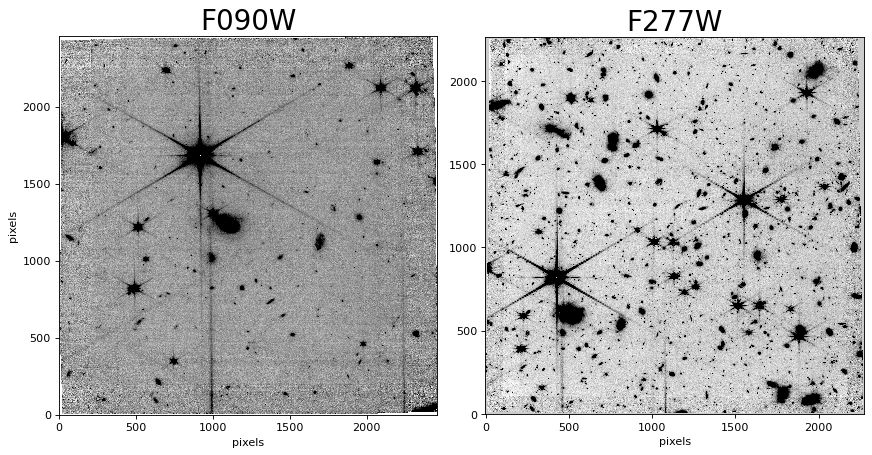

In [21]:
plot_images(os.path.join(output_dir, 'f090w_nrca1_i2d.fits'),
            os.path.join(output_dir, 'f277w_nrcalong_i2d.fits'), 
            title1='F090W', title2='F277W')

The A1 detector overlaps the lower left quadrant of the A5 detector, and so the F090W image on the left covers the same region as the first ~1024 pixels in both *x* and *y* of the F277W image on the right. 

<a id='command_line_image3'></a>
#### Call the pipeline using the command line

In the cell below we provide two commands that use `strun` to call the *calwebb_image3* pipeline with the two ASN files.

<div class="alert alert-block alert-info">

    
```
strun image3_swc_edited.asdf f090w_nrca1.json 
   
strun image3_lwc_edited.asdf f277w_nrca5.json
    
```
</div>

This concludes the processing steps for this notebook. 

Possible optimization:
- background subtraction (on cal level)
- astrometry
- wisp and snowball removal / flagging
- parameters of pipeline (many!)